# IMPORTS E INSTALAÇÕES
---

In [ ]:
%pip install -r requirements.txt

In [44]:
from ucimlrepo import fetch_ucirepo # https://archive.ics.uci.edu/dataset/45/heart+disease

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical


# import tensorflow as tf
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

# import funcoes_auxiliares as faux
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# FUNÇÕES AUXILIARES
---

In [45]:
def busca_registros_faltantes(df):
    # Verifica quais colunas têm pelo menos um dado faltante
    colunas_com_faltantes = df.columns[df.isnull().any()]

    # Filtra o dataframe original para incluir apenas as colunas com faltantes
    subdataframe = df[colunas_com_faltantes]

    # Verifica quais linhas têm pelo menos um dado faltante no subdataframe
    linhas_com_faltantes = subdataframe.index[subdataframe.isnull().any(axis=1)]

    # Filtra novamente o subdataframe para incluir apenas as linhas com faltantes
    subdataframe = subdataframe.loc[linhas_com_faltantes]

    return subdataframe

def plot_historico(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # Imprime a curva de aprendizado
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # Imprime a curva de acurácia
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

  #fig.savefig('/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/' + title)
  #plt.show()

def correlacao_e_visualizacao(dataset, target_column, method='pearson', threshold=0.6):
    # Calcular a correlação
    correlacao = dataset.corrwith(dataset[target_column], method=method)

    # Selecionar colunas com base no limiar de correlação
    colunas_selecionadas = correlacao[(correlacao >= threshold) | (correlacao <= -threshold)].index

    # Criar um DataFrame com as correlações
    correlations = pd.DataFrame({method.capitalize(): correlacao})

    # Criar um mapa de calor com as correlações originais
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(data=correlations, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f"Correlação com '{target_column}'")

    # Criar um novo DataFrame com as colunas selecionadas
    dataset_filtrado = dataset[colunas_selecionadas]

    # Calcular as correlações para o DataFrame filtrado
    correlacao_filtrada = dataset_filtrado.corrwith(dataset[target_column], method=method)

    # Criar um mapa de calor para as correlações filtradas
    sns.heatmap(data=pd.DataFrame({method.capitalize(): correlacao_filtrada}), annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f"Correlação de {method.capitalize()} (Filtrada)")

    plt.tight_layout()
    plt.show()

def exibir_metricas_classificacao(classe_teste, previsoes):
    # Calcular métricas
    acuracia = accuracy_score(classe_teste, previsoes)
    precisao = precision_score(classe_teste, previsoes, average="micro")
    recall = recall_score(classe_teste, previsoes, average="micro")
    f1score = f1_score(classe_teste, previsoes, average="micro")

    # Criar um DataFrame para exibir as métricas
    df = pd.DataFrame({
        'Acurácia': [acuracia],
        'Precisão': [precisao],
        'Recall': [recall],
        'F1-Score': [f1score]
    })

    return df

def exibir_matriz_confusao(classe_teste, previsoes):
    matriz = confusion_matrix(classe_teste, previsoes)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = np.arange(1, len(val_loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history, metric_name='categorical_accuracy'):
    history_dict = history.history
    acc_values = history_dict[metric_name]
    val_acc_values = history_dict['val_' + metric_name]

    epochs = np.arange(1, len(val_acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



# EXTRAÇÃO DOS DADOS
---

## Limpeza dos dados

In [47]:
# Buscando de csv local
dataset = pd.read_csv("dados-cleveland.csv", sep=",")

# Verificar se há dados faltantes
dataset.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Segundo o método 'describe' nenhuma coluna possui dados faltantes. Abaixo usarei um método auxiliar que não deve retornar nada se isso for verdade.

In [46]:
# verificar se há dados faltantes no dataset com função auxiliar
busca_registros_faltantes(dataset)

""


In [52]:
dataset_filtrado = dataset # fiz isso somente por padrão entre 'notebooks'

## Verificando correlação

In [54]:
# Supondo que você tenha um DataFrame chamado 'dataset'
print(dataset_filtrado.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


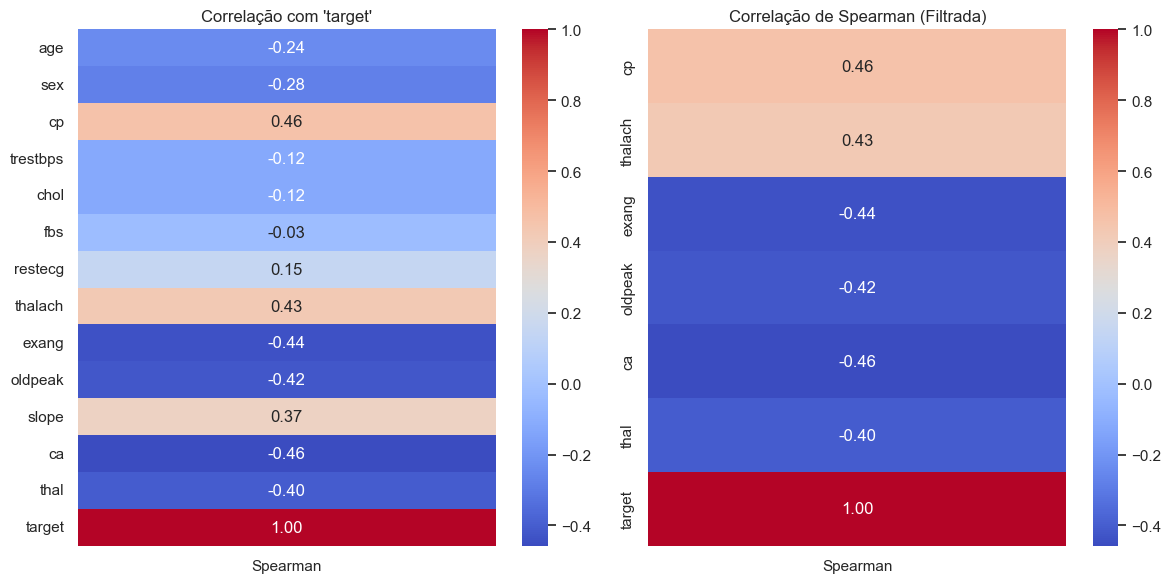

In [55]:
correlacao_e_visualizacao(dataset_filtrado, 'target', method='spearman', threshold=0.4)

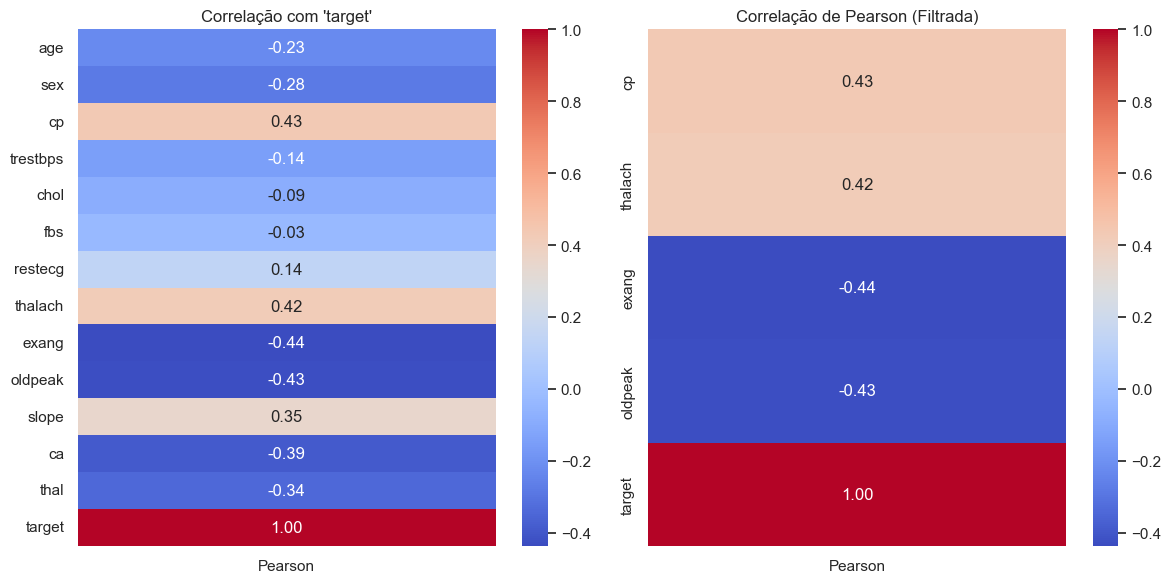

In [56]:
correlacao_e_visualizacao(dataset_filtrado, 'target', method='pearson', threshold=0.4)

In [57]:
# Lista de colunas que deseja manter
colunas_desejadas = ['target', 'thal', 'ca', 'oldpeak', 'exang', 'thalach', 'cp']

# Sobrescreva o dataset com as colunas desejadas (caso queira usar para algum teste de modelo)
dataset_filtrado_correlacao = dataset_filtrado[colunas_desejadas]

# TRANSFORMAÇÃO DOS DADOS
---

## Obtendo Classe e Previsores

In [58]:
# Previsores
X = dataset_filtrado.drop(columns=["target"]).values

# Classe
Y = dataset_filtrado["target"].values

## Codificação 

Sem necessidade

## Normalização

In [59]:
# Crie uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Ajuste o scaler aos dados e, ao mesmo tempo, normalize os dados
X = scaler.fit_transform(X)

# CARREGANDO DADOS (MODELO)
---

##  Separando Teste e Treino

In [60]:
# Base de treino e teste
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25)

## Criando modelo

In [61]:
classificador = Sequential()
classificador.add(Dense(units=1, activation='sigmoid', kernel_initializer='random_uniform', input_dim=len(dataset_filtrado.columns) - 1))

## Compilando o modelo

In [62]:
classificador.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Treinando o modelo

In [63]:
history = classificador.fit(train_x, train_y, batch_size=5, epochs=200, validation_split=0.3)

Epoch 1/200
32/32 [==============================] - 1s 14ms/step - loss: 0.6849 - accuracy: 0.6835 - val_loss: 0.6795 - val_accuracy: 0.8261
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.7722 - val_loss: 0.6727 - val_accuracy: 0.8406
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.7848 - val_loss: 0.6649 - val_accuracy: 0.8551
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.7911 - val_loss: 0.6605 - val_accuracy: 0.8261
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.8101 - val_loss: 0.6546 - val_accuracy: 0.8261
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.8038 - val_loss: 0.6472 - val_accuracy: 0.8261
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.8038 - val_loss: 0.6425 - val_accuracy: 0.8406
Epoch 8/200


# MÉTRICAS E DESEMPENHO
---

In [64]:
# Realizando previsões
previsoes_teste = classificador.predict(test_x)
previsoes_teste = (previsoes_teste > 0.5)

3/3 [==============================] - 0s 2ms/step


In [65]:
exibir_metricas_classificacao(test_y, previsoes_teste)

,Acurácia,Precisão,Recall,F1-Score
0,0.828947,0.828947,0.828947,0.828947


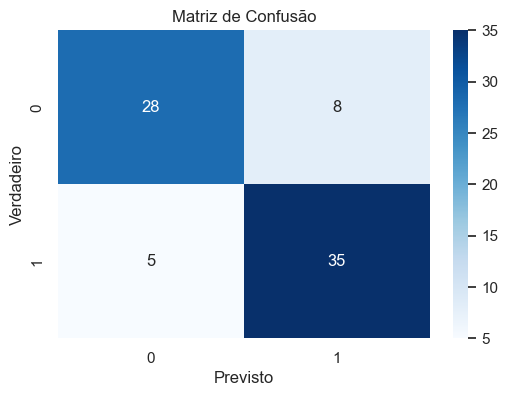

In [66]:
exibir_matriz_confusao(test_y, previsoes_teste)

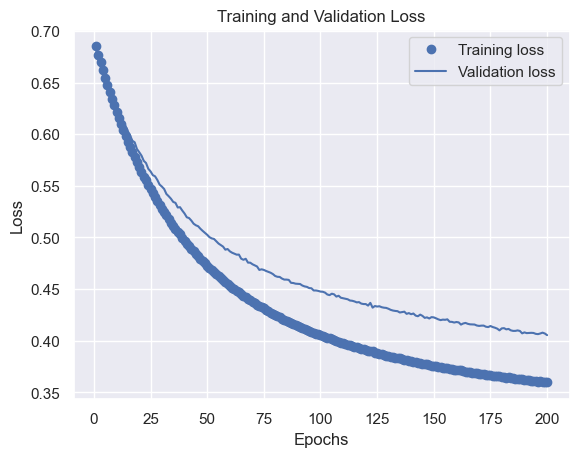

In [67]:
plot_loss(history)

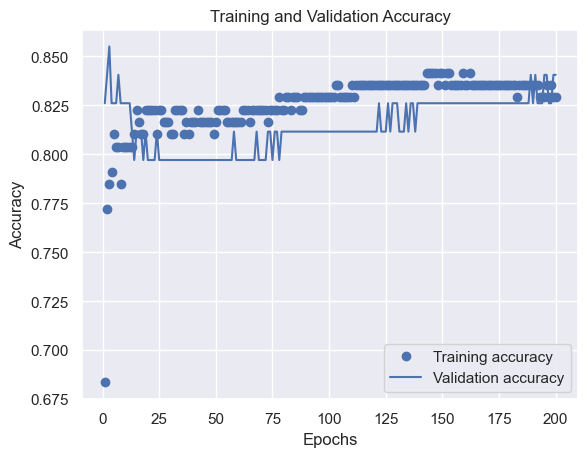

In [68]:
plot_accuracy(history, metric_name='accuracy')

# EXPORTANDO DADOS
---

In [69]:
import os

# Diretório atual
save_dir = os.getcwd()

# Caminho para os arquivos
arquitetura_path = os.path.join(save_dir, "arquitetura_rede.json")
pesos_path = os.path.join(save_dir, "pesos_rede.h5")

# Salve a arquitetura em JSON
arquitetura = classificador.to_json()
with open(arquitetura_path, "w") as json_file:
    json_file.write(arquitetura)

# Salve os pesos da rede
classificador.save_weights(pesos_path)

print(f"Arquivos salvos em: {save_dir}")

Arquivos salvos em: c:\Users\Mathe\projetos\EoC-AI-IFES\lista3-cleveland-dataset
